In [1]:
import torch
print(torch.backends.mps.is_available())  # Should print True
print(torch.backends.mps.is_built())      # Should print True

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np

True
True


In [3]:
device = torch.device("mps")
print(device)

mps


In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))])
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

In [5]:
print('Number of images in the training dataset:', len(train_set))
print('Number of images in the testing dataset:', len(test_set))
print(f"Shape of the images in the training dataset: {train_loader.dataset[0][0].shape}")

Number of images in the training dataset: 60000
Number of images in the testing dataset: 10000
Shape of the images in the training dataset: torch.Size([1, 28, 28])


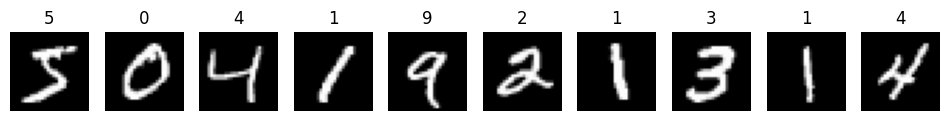

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i in range(10):
  axes[i].imshow(train_loader.dataset[i][0].squeeze(), cmap='gray')
  axes[i].set_title(train_loader.dataset[i][1])
  axes[i].axis('off')
plt.show()

In [7]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.input = nn.Linear(28*28, 128)
    self.hidden_1 = nn.Linear(128, 256)
    self.hidden_2 = nn.Linear(256, 256)
    self.hidden_3 = nn.Linear(256, 128)
    self.hidden_4 = nn.Linear(128, 64)
    self.output = nn.Linear(64, 10)

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = F.gelu(self.input(x))
    x = F.gelu(self.hidden_1(x))
    x = F.gelu(self.hidden_2(x))
    x = F.gelu(self.hidden_3(x))
    x = F.gelu(self.hidden_4(x))
    x = F.log_softmax(self.output(x), dim=1)
    return x

model = NeuralNetwork().to(device)

In [8]:
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
  for images, labels in train_loader:
    optimizer.zero_grad()

    output = model(images.to(device))
    loss = loss_function(output, labels.to(device))

    loss.backward()
    optimizer.step()

  print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.3256
Epoch [2/10], Loss: 0.0109
Epoch [3/10], Loss: 0.0149
Epoch [4/10], Loss: 0.0279
Epoch [5/10], Loss: 0.0243
Epoch [6/10], Loss: 0.2538
Epoch [7/10], Loss: 0.2308
Epoch [8/10], Loss: 0.0009
Epoch [9/10], Loss: 0.1717
Epoch [10/10], Loss: 0.0242


In [9]:
def view_classify(image, probabilities):
    probabilities = probabilities.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(image.numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), probabilities)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

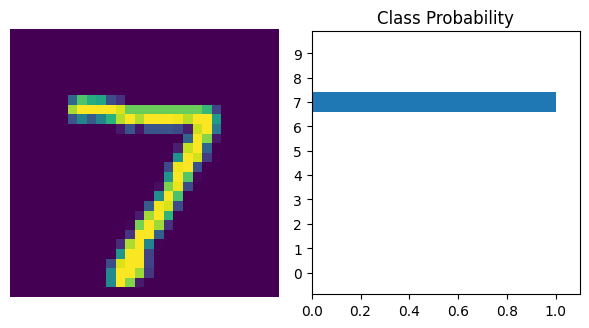

In [10]:
images, _ = next(iter(test_loader))

image = images[0].to(device)
with torch.no_grad():
    log_probabilities = model(image)

probabilities = torch.exp(log_probabilities)

# When displaying/plotting, move back to CPU
view_classify(image.cpu().view(1, 28, 28), probabilities.cpu())

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the neural network on the {total} test images: {100 * correct / total}%')

Accuracy of the neural network on the 10000 test images: 97.43%
